## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0804 17:46:56.618627  1048 deprecation_wrapper.py:119] From D:\Software\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0804 17:46:56.619567  1048 deprecation_wrapper.py:119] From D:\Software\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0804 17:46:56.639087  1048 deprecation_wrapper.py:119] From D:\Software\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 17:46:56.641039  1048 deprecation_wrapper.py:119] From D:\Software\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 17:46:56.643968  1048 deprecation_

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0804 17:46:56.958239  1048 deprecation.py:323] From D:\Software\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 137us/step - loss: 15.0752 - acc: 0.2625 - val_loss: 13.9452 - val_acc: 0.3233
Epoch 2/50
50000/50000 [==============================] - 4s 73us/step - loss: 13.0062 - acc: 0.3547 - val_loss: 12.1130 - val_acc: 0.3757
Epoch 3/50
50000/50000 [==============================] - 4s 72us/step - loss: 11.3336 - acc: 0.3794 - val_loss: 10.5832 - val_acc: 0.3959
Epoch 4/50
50000/50000 [==============================] - 4s 72us/step - loss: 9.9212 - acc: 0.3948 - val_loss: 9.2865 - val_acc: 0.4026
Epoch 5/50
50000/50000 [==============================] - 4s 74us/step - loss: 8.7216 - acc: 0.4062 - val_loss: 8.1777 - val_acc: 0.4146
Epoch 6/50
50000/50000 [==============================] - 4s 75us/step - loss: 7.6986 - acc: 0.4152 - val_loss: 7.2337 - val_acc: 0.4241
Epoch 7/50
50000/50000 [==============================] - 4s 73us/step - loss: 6.8273 - acc: 0.4202 - val_loss: 6.4366 - 

50000/50000 [==============================] - 4s 77us/step - loss: 1.9405 - acc: 0.3644 - val_loss: 1.8895 - val_acc: 0.3825
Epoch 3/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.8568 - acc: 0.3964 - val_loss: 1.8285 - val_acc: 0.4041
Epoch 4/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.7974 - acc: 0.4158 - val_loss: 1.7798 - val_acc: 0.4237
Epoch 5/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.7517 - acc: 0.4330 - val_loss: 1.7424 - val_acc: 0.4322
Epoch 6/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.7102 - acc: 0.4502 - val_loss: 1.7056 - val_acc: 0.4451
Epoch 7/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.6770 - acc: 0.4620 - val_loss: 1.6804 - val_acc: 0.4583
Epoch 8/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.6464 - acc: 0.4720 - val_loss: 1.6592 - val_acc: 0.4660
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 4s 74us/step - loss: 1.7208 - acc: 0.3966 - val_loss: 1.6980 - val_acc: 0.4099
Epoch 4/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.6633 - acc: 0.4175 - val_loss: 1.6620 - val_acc: 0.4080
Epoch 5/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.6171 - acc: 0.4334 - val_loss: 1.6034 - val_acc: 0.4366
Epoch 6/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.5766 - acc: 0.4477 - val_loss: 1.5720 - val_acc: 0.4452
Epoch 7/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.5421 - acc: 0.4597 - val_loss: 1.5467 - val_acc: 0.4537
Epoch 8/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.5101 - acc: 0.4705 - val_loss: 1.5215 - val_acc: 0.4623
Epoch 9/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.4818 - acc: 0.4805 - val_loss: 1.5036 - val_acc: 0.4671
Epoch 10/50
50000/50000 [===========================

50000/50000 [==============================] - 4s 73us/step - loss: 1.6698 - acc: 0.4140 - val_loss: 1.6503 - val_acc: 0.4167
Epoch 5/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.6220 - acc: 0.4304 - val_loss: 1.6163 - val_acc: 0.4326
Epoch 6/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.5798 - acc: 0.4459 - val_loss: 1.5745 - val_acc: 0.4445
Epoch 7/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.5440 - acc: 0.4583 - val_loss: 1.5519 - val_acc: 0.4505
Epoch 8/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.5139 - acc: 0.4682 - val_loss: 1.5285 - val_acc: 0.4584
Epoch 9/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.4846 - acc: 0.4777 - val_loss: 1.5243 - val_acc: 0.4549
Epoch 10/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.4562 - acc: 0.4881 - val_loss: 1.4879 - val_acc: 0.4729
Epoch 11/50
50000/50000 [==========================

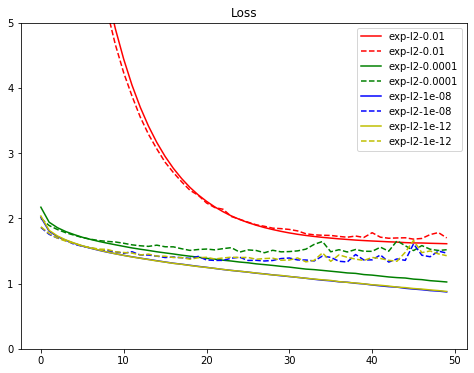

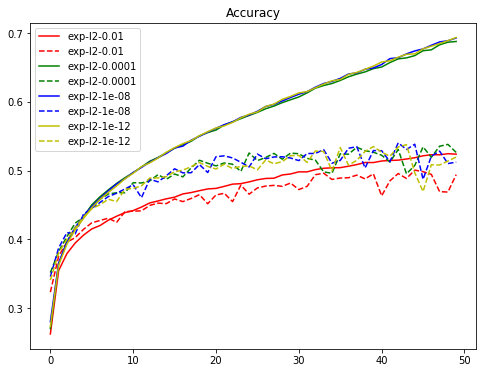

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()